In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
sp1950 = yf.download('^GSPC', start='1950-01-01')
nya1965 = yf.download('^NYA', start='1965-01-01')
nasdaq1965 = yf.download('^IXIC', start='1965-01-01')
wilshire1990 = yf.download('^W5000', start='1990-01-01')

path = '../data'
sp1950.to_csv(f'{path}/sp1950.csv')
nya1965.to_csv(f'{path}/nya1965.csv')
nasdaq1965.to_csv(f'{path}/nasdaq1965.csv')
wilshire1990.to_csv(f'{path}/wilshire1990.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'ADYEY', 'AMD', 'AMZN', 'ANET', 'APPH',
    'AXON', 'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG',
    'DKNG', 'DOCS', 'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT',
    'FUV', 'FVRR', 'GH', 'GMED', 'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD',
    'LULU', 'MDB', 'MELI', 'MNST', 'MSFT', 'MTCH', 'NVCR', 'NVDA',
    'NYT', 'OKTA', 'OPEN', 'PANW', 'PINS', 'PTON', 'QDEL', 'RBLX',
    'RDFN', 'RGEN', 'RIVN', 'ROKU', 'RVLV', 'SE', 'SHOP', 'SNOW',
    'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO', 'TWLO',
    'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']

INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

72

In [4]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 5
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2017, 6, 12), datetime.date(2022, 6, 11))

In [5]:
batch = SYMBOLS #+ INDICES

In [6]:
data = (yf.download(batch, start=START, end=TODAY)
        .rename(columns={'Adj Close': 'AdjClose'}))

[*********************100%***********************]  72 of 72 completed


In [7]:
data.tail()

AdjClose                                              \
                  AAPL        ABMD        ABNB   ADYEY         AMD   
Date                                                                 
2022-06-06  146.139999  260.100006  122.019997  16.010  105.650002   
2022-06-07  148.710007  268.230011  122.900002  15.710  105.279999   
2022-06-08  147.960007  265.359985  123.769997  15.430  101.900002   
2022-06-09  142.639999  257.109985  115.720001  14.790   98.800003   
2022-06-10  137.130005  250.429993  108.910004  14.048   94.820000   

                                                                 ...   Volume  \
                  AMZN        ANET  APPH        AXON       BROS  ...      TTD   
Date                                                             ...            
2022-06-06  124.790001  103.510002  2.86  102.680000  41.700001  ...  4820300   
2022-06-07  123.000000  104.300003  2.89  104.070000  40.259998  ...  4570400   
2022-06-08  121.180000  103.050003  2.89  102.879997  39.250000  ...  3432800   
2022-06-09  116.150002   98.410004  2.72  101.040001  39.160000  ...  4557600   
2022-06-10  109.650002   94.889999  2.66   96.510002  34.400002  ...  4961582   

                                                                    \
               TTWO     TWLO      TWTR       UPST     VEEV      WK   
Date                                                                 
2022-06-06  1971500  2720600  26119600  5305300.0  1301500  285200   
2022-06-07  2697500  3622300  15808700  6649600.0  1260300  213800   
2022-06-08  1559300  1899600  15293000  6034300.0   929300  227100   
2022-06-09  2966200  3712800   7970300  8168900.0   904900  194900   
2022-06-10  2205925  5215961   8346302  6831353.0   897418  205038   

                                       
                  XPEV       ZEN ZNGA  
Date                                   
2022-06-06  11097300.0   2767800  NaN  
2022-06-07   8254400.0   1915600  NaN  
2022-06-08  14003400.0   7273700  NaN  
2022-06-09  11785400.0  11055000  NaN  
2022-06-10  10925696.0   4138275  NaN  

[5 rows x 432 columns]

In [8]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    sub.fillna(method='ffill', inplace=True)
    return sub

In [9]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [10]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [11]:
def rescale(a):
    a = a - a.min()
    a = a / a.max()
    return a

In [12]:
def vals_to_quantiles(a):
    n = len(a)
    qs = np.linspace(0, 1, n)
    order = np.argsort(a)
    out = qs[order]
    return out

In [13]:
def get_rsi(stock_data, window=14):
    df = stock_data.copy()
    df['deltas'] = df.AdjClose.diff(1)
    df['gains'] = df.deltas.clip(lower=0)
    df['losses'] = df.deltas.clip(upper=0).abs()
    df['avg_gain'] = (df.gains
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    df['avg_loss'] = (df.losses
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    
    # avg gains
    pd.options.mode.chained_assignment = None
    for i, row in enumerate(df.avg_gain.iloc[window + 1:]):
        df.avg_gain.iloc[i + window + 1] = (
            (df.avg_gain.iloc[i + window] * (window - 1) 
             + df.gains.iloc[i + window + 1]) 
            / window)
    # avg losses
    for i, row in enumerate(df.avg_loss.iloc[window + 1:]):
        df.avg_loss.iloc[i + window + 1] = (
            (df.avg_loss.iloc[i + window] * (window - 1)
             + df.losses.iloc[i + window + 1])
            / window)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1. + df.rs))
    return df.rsi

In [14]:
def get_macd(stock_data, fast=60, slow=90, signal=80, plot=False):
    df = stock_data.copy()
    exp1 = df.AdjClose.ewm(span=fast, adjust=False).mean()
    exp2 = df.AdjClose.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=signal, adjust=False).mean()
    histo = macd - exp3
    hdiff = histo.diff(1)
    is_rising = 1 * (hdiff > 0)
    if plot:
        plt.plot(macd, label='MACD', color='red')
        plt.plot(exp3, label='Signal', color='green')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.legend();
        plt.figure()
        plt.plot(histo, color='blue')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.axhline(y=0, color='k')
        plt.figure()
        plt.plot(is_rising)
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
    return is_rising

In [15]:
LMB = 0.9
RSI_WINDOW = 14
MACD_PARAMS = (60, 90, 80, False)

In [16]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    n = len(stock_data.AdjClose[~np.isnan(stock_data.AdjClose)])
    stock_data['direction'] = get_macd(stock_data, *MACD_PARAMS)
    stock_data['rsi'] = get_rsi(stock_data, window=RSI_WINDOW)
    stock_data.rsi = stock_data.rsi.rank(pct=True)
    sharpe = get_sharpe(get_daily_returns(stock_data.AdjClose))
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    WINDOW = min(n // 2, 125)
    stock_data['ann_high'] = (stock_data.AdjClose
                              .rolling(window=WINDOW)
                              .max())
    stock_data['ann_low'] = (stock_data.AdjClose
                             .rolling(window=WINDOW)
                             .min())
    stock_data['drawdown'] = stock_data.AdjClose / stock_data.ann_high
    stock_data.drawdown = stock_data.drawdown.rank(pct=True)
    stock_data['pullup'] = stock_data.AdjClose / stock_data.ann_low
    #return stock_data.pullup
    stock_data.pullup = stock_data.pullup.rank(pct=True)
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = ((stock_data.Close 
                            + stock_data.High 
                            + stock_data.Low 
                            + stock_data.Open) 
                           / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.AdjClose / stock_data.est
    stock_data.resid = stock_data.resid.rank(pct=True)
    stock_data.sort_values('resid', inplace=True)
    stock_data['dev'] = np.array(range(n)) / n
    stock_data.dev = stock_data.dev.rank(pct=True)
    stock_data.sort_index(inplace=True)
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.Close, label='Close')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.plot(stock_data.ann_high, color='green')
        plt.plot(stock_data.ann_low, color='red')
        plt.legend();
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.dev)
        plt.axhline(0.5, color='k')
        plt.title(stock)
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.drawdown, color='red', label='drawdown')
        plt.plot(stock_data.pullup, color='green', label='pullup')
        plt.plot(np.sqrt(stock_data.drawdown * stock_data.pullup),
                 color='grey',
                 label='geomean')
        plt.yscale('log')
        plt.legend()
    return (stock_data.direction.tolist()[-1],
            stock_data.rsi.tolist()[-1],
            stock_data.resid.tolist()[-1], 
            stock_data.dev.tolist()[-1],
            stock_data.drawdown.tolist()[-1],
            stock_data.pullup.tolist()[-1],
            sharpe)

(0,
 0.10834670947030497,
 0.0373015873015873,
 0.0373015873015873,
 0.014964788732394365,
 0.136443661971831,
 0.6524468592268826)

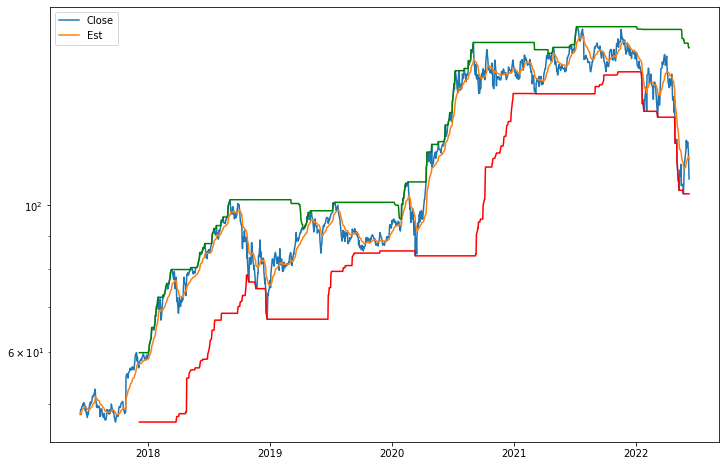

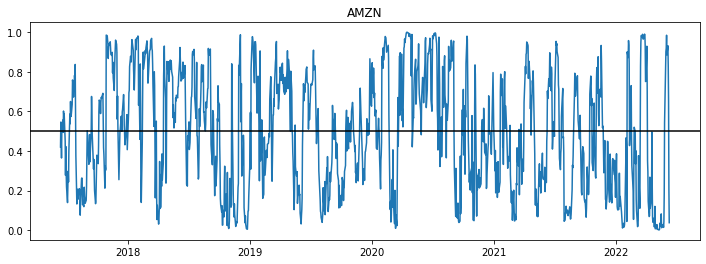

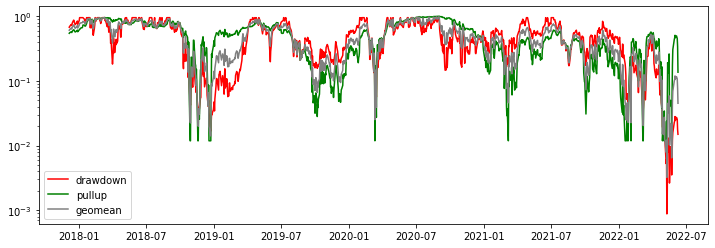

In [17]:
process_stock('AMZN', data.copy(), plot=True)

In [18]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    direction, rsi, mult, dev, drop, climb, sharpe = process_stock(
        stock, data)
    out.append([stock, direction, rsi, mult, dev, drop, climb, sharpe])

AAPL... ABMD... ABNB... ADYEY... AMD... AMZN... ANET... APPH... AXON... BROS... BYND... CHWY... COIN... COUR... CRWD... DDOG... DKNG... DOCS... DOCU... DUOL... EDIT... ETSY... FLGT... FUV... FVRR... GH... GMED... GOOG... INTG... ISRG... JD... LSPD... LULU... MDB... MELI... MNST... MSFT... MTCH... NVCR... NVDA... NYT... OKTA... OPEN... PANW... PINS... PTON... QDEL... RBLX... RDFN... RGEN... RIVN... ROKU... RVLV... SE... SHOP... SNOW... SPLK... SQ... TASK... TDOC... TEAM... TREX... TTD... TTWO... TWLO... TWTR... UPST... VEEV... WK... XPEV... ZEN... ZNGA... 

In [19]:
out = pd.DataFrame(
    data=out, 
    columns=['stock', 'direction', 'RSI', 'fair_value_mult', 
             'dev_quantile', 'drop','climb', 'sharpe'])
out['geomean'] = np.sqrt(out['drop'] * out.climb)
out['score'] = (out.fair_value_mult
                * out.dev_quantile
                * out['drop']
                * out.climb) ** (1/4) 
out['RSIRev'] = 1 - out.RSI
out = out[['stock', 'direction', 'RSI', 'RSIRev', 'fair_value_mult', 
           'dev_quantile', 'drop', 'climb','geomean', 'score', 
           'sharpe']]
out.RSI.fillna(out.RSI.median())
out.RSIRev.fillna(out.RSIRev.median())

out.sort_values('stock')

,stock,direction,RSI,RSIRev,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe
0,AAPL,0,0.077849,0.922151,0.101587,0.101587,0.060739,0.007482,0.021318,0.046537,1.024020
1,ABMD,1,0.261637,0.738363,0.244444,0.244444,0.160211,0.222711,0.188894,0.214881,0.488450
2,ABNB,0,0.120879,0.879121,0.076720,0.076720,0.039370,0.055118,0.046583,0.059782,0.005187
3,ADYEY,0,0.109940,0.890060,0.050147,0.050147,0.018051,0.034296,0.024881,0.035323,0.850732
4,AMD,1,0.247994,0.752006,0.188095,0.188095,0.060739,0.146127,0.094211,0.133119,1.019788
...,...,...,...,...,...,...,...,...,...,...,...
67,VEEV,1,0.517657,0.482343,0.619841,0.619841,0.076585,0.399648,0.174948,0.329302,0.756122
68,WK,1,0.077849,0.922151,0.039683,0.039683,0.014085,0.080986,0.033773,0.036609,0.803812
69,XPEV,1,0.755149,0.244851,0.804878,0.804878,0.360856,0.302752,0.330530,0.515787,0.526678
70,ZEN,0,0.001605,0.998395,0.001587,0.001587,0.000880,0.017606,0.003937,0.002500,0.629527


In [20]:
out.geomean.quantile([0.05, 0.99])

0.05    0.010617
0.99    0.818447
Name: geomean, dtype: float64

In [21]:
out.to_csv('individ_quantiles.csv', index=False)

In [22]:
!open individ_quantiles.csv